In [2]:
"""
This file is implementing the vanilla LSTM.
The test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.
Missing days are estimated.
Naive basemodels that are used are the mean forecast and the MAPE-minimization.
Evaluation metrics used: MSE, RMSE, NRMSE, MAE
####################################################

calculate the MSE on the total test set and for each day of the week.
Should normalize history and temperature with min max
Rest: weekday, time, holiday use one hot encoder
Stack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's
Use finally a fully connected layer to generate an output
Use different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp
Adam has parameters: learning rate, momentum and decay
play with mini batches

Inputs:
1. history ok
2. temp ok
3. day week ok
4. time ok
5. holiday
6. (previous week future lag)
7. previous week error history lag --> how good are you following previous week
just the difference between the values
8. previous weeks load at the same moment in time and the temperatures of these days
"""


"\nThis file is implementing the vanilla LSTM.\nThe test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.\nMissing days are estimated.\nNaive basemodels that are used are the mean forecast and the MAPE-minimization.\nEvaluation metrics used: MSE, RMSE, NRMSE, MAE\n####################################################\n\ncalculate the MSE on the total test set and for each day of the week.\nShould normalize history and temperature with min max\nRest: weekday, time, holiday use one hot encoder\nStack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's\nUse finally a fully connected layer to generate an output\nUse different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp\nAdam has parameters: learning rate, momentum and decay\nplay with mini batches\n\nInputs:\n1. history ok\n2. temp ok\n3. day week ok\n4. time ok\n5. holiday\n6. (previous week future lag)\n7. p

In [3]:
import datetime as dt
import pandas as pd # pandas
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import casadi as ca
from Test_basemodel_functions import *

plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('figure',figsize=(10,8))


In [4]:
# importing the data
fullYeardata = pd.read_csv("D:\Onedrive\Leuven\Final project\data\Forecasting_writtendata\FullYear.csv",index_col= "date",parse_dates= True)
av_temperature = pd.read_csv("D:\Onedrive\Leuven\Final project\data\weather-avg.csv",index_col='meter_id')
av_temperature = av_temperature.transpose()
av_temperature.index = pd.to_datetime(av_temperature.index)

In [5]:
name = fullYeardata.columns[0]
TS = fullYeardata[name]
temperature = av_temperature[name]

In [6]:
# subsitute the missing values by prev week < prev day < mean of all the values at that time of the day (rarely used)
def substitute_missing_values(TS: pd.Series):
    for date in TS.index:
        if np.isnan(TS[date]):
            prev_week =  date + dt.timedelta(days=-7)
            prev_day = date + dt.timedelta(days=-1)
            if not np.isnan(TS[prev_week]):
                TS[date] = TS[prev_week]

            elif not np.isnan(TS[prev_day]):
                TS[date] = TS[prev_day]

            else:
                temp = TS[TS.index.hour == date.hour]
                data = temp[temp.index.minute == date.minute]
                TS[date] = data.mean()
    print("amount of missing values: %s. \n"%TS.isnull().sum())
    return TS

In [107]:
# all the training dates are present, dates from the test set can be missing.

# normalize the data --> min/max method (when using a single time serie)
temperature_norm = norm(temperature)
TS_norm = norm(TS)
# temp = TS_norm[TS_norm.index.month != 12]
# training = temp[temp != 11]
# validation = TS_norm[TS_norm.index.month == 11]
# test = TS_norm[TS_norm.index.month == 12]
# remove from the test set all the days that contain nan values -> only estimate real days
training = TS_norm[0:336]
validation = TS_norm[336:384]
test = TS_norm[384:528]
test.dropna(inplace=True)
# substitute the missing values
training = substitute_missing_values(training)
TS_norm_full = substitute_missing_values(TS_norm)

amount of missing values: 0. 

amount of missing values: 0. 



In [8]:
def get_av_temp(time_stamp: pd.Timestamp,temperature: pd.Series)-> float:
    return temperature[temperature.index.dayofyear == time_stamp.dayofyear]

def get_weekday(time_stamp: pd.Timestamp)-> int:
    return time_stamp.weekday()

def get_daytime(time_stamp: pd.Timestamp):
    value = time_stamp.hour*2
    if time_stamp.minute == 30:
        value = value + 1
    return value

def is_holiday(time_stamp: pd.Timestamp, holidays: pd.DatetimeIndex)->bool:
    return any(time_stamp.dayofyear == holidays.dayofyear)


# forecast one time stamp at the time --> for loop to forecast the 48 time stamps
def input_output_LSTM(training, temperature_norm, lag_value: int):
    holidays = EnglandAndWalesHolidayCalendar().holidays(start=pd.Timestamp('2017-01-01'),end=pd.Timestamp('2017-12-31'))
    amount_forecasts = len(training) - lag_value
    amount_features = 1+1+7+48+2
    X = np.zeros((amount_forecasts,lag_value,amount_features))
    y = np.zeros((amount_forecasts,1))

    for sample_id in np.arange(0,amount_forecasts):

        history = training.values[sample_id:lag_value + sample_id]
        y[sample_id] = training.values[lag_value + sample_id]
        X[sample_id,:,0] = history
        all_time_stamps = training.index[sample_id:lag_value + sample_id]
        for lag_value_index in np.arange(0,lag_value): # goes from old to new
            time_stamp = all_time_stamps[lag_value_index]

            temperature_feed = get_av_temp(time_stamp,temperature_norm)
            X[sample_id,lag_value_index,1] = temperature_feed

            weekday = np.zeros(7)
            day = get_weekday(time_stamp) # 0 - 6
            weekday[day] = 1
            X[sample_id,lag_value_index,2:9] = weekday

            time = np.zeros(48)
            time_of_day = get_daytime(time_stamp) # 0 - 47
            time[time_of_day] = 1
            X[sample_id,lag_value_index,9:57] = time

            holiday = np.zeros(2)
            hol = is_holiday(time_stamp,holidays) # [no, yes]
            if hol:
                holiday[1] = 1
            else:
                holiday[0] = 1
            X[sample_id,lag_value_index,57:59] = holiday


    return X,y


In [9]:
from keras.layers import Dense,  LSTM,Embedding
from keras.models import Sequential, save_model, load_model
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint, History

path_checkpoint = "model_checkpoint.h5"
modelckpt_callback = ModelCheckpoint(monitor="val_loss",filepath=path_checkpoint,verbose=1,save_weights_only=True,save_best_only=True)
def build_model(training: pd.Series,validation: pd.Series, temperature_norm: pd.Series, lag_value: int,nb_epoch: int = 1, regularization_parameter: float = 0.01,batch_size_para: int = 32,verbose_para: int = 1, save: bool = False):
    history = History()
    X,y = input_output_LSTM(training, temperature_norm, lag_value)
    X_val,y_val = input_output_LSTM(validation, temperature_norm, lag_value)
    regularizers.l2(l=regularization_parameter)
    model = Sequential()
    # no initial state is given --> hidden state are tensors filled with zeros
    # dropout=None,recurrent_dropout=None
    model.add(LSTM(units=20,activation='tanh',input_shape=(X.shape[1],X.shape[2])))
    model.add(Dense(units=20,activation='relu',kernel_regularizer='l2'))
    # model.add(Dropout(0.10))
    model.add(Dense(units=y.shape[1],activation='relu',kernel_regularizer='l2'))
    model.compile(optimizer='adam',loss='mse')
    early_stopping_monitor = EarlyStopping(patience=2,restore_best_weights=True)
    model.fit(x=X,y=y,epochs=nb_epoch,batch_size=batch_size_para,validation_data=(X_val,y_val),callbacks=[early_stopping_monitor,modelckpt_callback,history],verbose=verbose_para)
    # save the trained_model
    if save:
        file_path = "./saved_model"
        save_model(model,file_path)

    return model,history

# model = load_model(filepath, compile = True)

Using TensorFlow backend.
D:\ProgrammaX100\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgrammaX100\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgrammaX100\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgrammaX100\Anaconda\env

In [10]:
trained_model,hist = build_model(training=training,validation=validation,temperature_norm=temperature_norm,lag_value=3,nb_epoch=150)


Train on 333 samples, validate on 45 samples
Epoch 1/150
333/333 [==============================] - 1s 2ms/step - loss: 0.2246 - val_loss: 0.2107

Epoch 00001: val_loss improved from inf to 0.21070, saving model to model_checkpoint.h5
Epoch 2/150
333/333 [==============================] - 0s 99us/step - loss: 0.2063 - val_loss: 0.1944

Epoch 00002: val_loss improved from 0.21070 to 0.19445, saving model to model_checkpoint.h5
Epoch 3/150
333/333 [==============================] - 0s 141us/step - loss: 0.1898 - val_loss: 0.1793

Epoch 00003: val_loss improved from 0.19445 to 0.17927, saving model to model_checkpoint.h5
Epoch 4/150
333/333 [==============================] - 0s 141us/step - loss: 0.1747 - val_loss: 0.1655

Epoch 00004: val_loss improved from 0.17927 to 0.16550, saving model to model_checkpoint.h5
Epoch 5/150
33

In [11]:
# predictions
# run the predictor ``warm'' on the trainingset --> before going to do predictions (remember matlab file)
# History().history
# loss = history.history["loss"]
# history.keys()

# hist = trained_model[1]

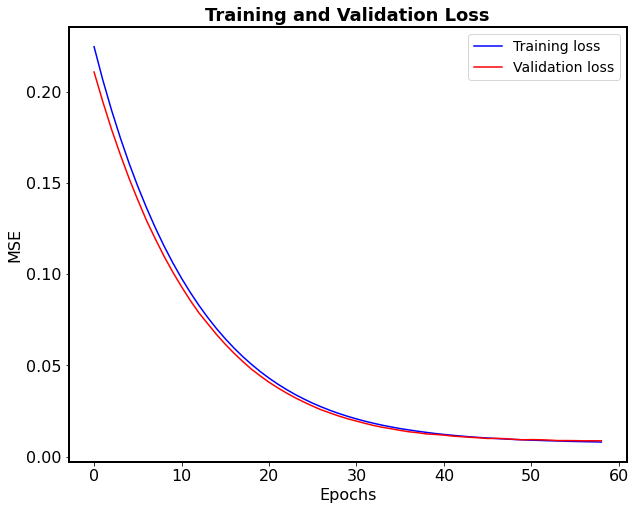

In [54]:
def visualize_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    figure_layout(figsize=(10,8),titel="Training and Validation Loss",xlabel="Epochs",ylabel="MSE",grid=False)
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.legend()
    plt.show()

visualize_loss(hist)

In [55]:
# trained_model.summary()

In [112]:
def daily_prediction(model: Sequential, TS_norm_full: pd.Series, temperature_norm: pd.Series, lag_value: int, daily_time_stamps: pd.DatetimeIndex):
    if len(daily_time_stamps) != 48:
            raise Exception("The test data doesn't equal 48 steps.")
    TS_copy = TS_norm_full.copy(deep= True)
    history_predictions = pd.Series(index= daily_time_stamps)
    history_reference = pd.Series(index= daily_time_stamps)
    for i in np.arange(0,len(daily_time_stamps)):
        time_stamp = daily_time_stamps[i]
        index_time_stamp = TS_copy.index.get_loc(time_stamp) # want to predict the time_stamp
        start = index_time_stamp - lag_value
        end = index_time_stamp
        history = TS[start:end+1]
        prediction_input, reference = input_output_LSTM(history, temperature_norm, lag_value)
        y_hat = model.predict(prediction_input)
        # integrate the prediction in the TS_copy to be used in the next iterate
        TS_copy[time_stamp] = y_hat
        history_predictions[i] = y_hat
        history_reference[i] = reference

    return history_predictions, history_reference

# print(time_step_prediction(model = trained_model, TS = TS, temperature_norm= temperature_norm, lag_value= 3, daily_time_stamps= pd.date_range(start=pd.Time)))


In [111]:
def get_all_days_of_year(serie: pd.Series)->set:
    collection = set()
    for date in serie.index:
        collection.add(date.dayofyear)
    return collection

In [110]:
def test_set_prediction(model: Sequential, TS_norm_full: pd.Series, temperature_norm: pd.Series, lag_value: int, test_set:pd.Series):
    # assumption that the test set has no gaps in the dates is not valid
    collection = list(get_all_days_of_year(test_set))
    day_int = collection[0]
    daily_time_stamps = test_set[test_set.index.dayofyear == day_int].index
    (history_predictions, history_reference) = daily_prediction(model, TS_norm_full, temperature_norm, lag_value, daily_time_stamps)
    all_predictions = history_predictions
    all_references = history_reference

    if len(collection) > 1:
        for day_int in collection[1:]:
            daily_time_stamps = test_set[test_set.index.dayofyear == day_int].index
            (history_predictions, history_reference) = daily_prediction(model, TS_norm_full, temperature_norm, lag_value, daily_time_stamps)
            print(history_predictions)
            all_predictions.append(history_predictions)
            all_references.append(history_reference)

    return all_predictions, all_references

In [118]:
print(TS_norm[432:480])

date
2017-01-10 00:00:00    0.046831
2017-01-10 00:30:00    0.033651
2017-01-10 01:00:00    0.044027
2017-01-10 01:30:00    0.038418
2017-01-10 02:00:00    0.038979
2017-01-10 02:30:00    0.043746
2017-01-10 03:00:00    0.033932
2017-01-10 03:30:00    0.045149
2017-01-10 04:00:00    0.037016
2017-01-10 04:30:00    0.077958
2017-01-10 05:00:00    0.049916
2017-01-10 05:30:00    0.038979
2017-01-10 06:00:00    0.040662
2017-01-10 06:30:00    0.043186
2017-01-10 07:00:00    0.036175
2017-01-10 07:30:00    0.048233
2017-01-10 08:00:00    0.031127
2017-01-10 08:30:00    0.048514
2017-01-10 09:00:00    0.033371
2017-01-10 09:30:00    0.088615
2017-01-10 10:00:00    0.046270
2017-01-10 10:30:00    0.050196
2017-01-10 11:00:00    0.040381
2017-01-10 11:30:00    0.049635
2017-01-10 12:00:00    0.047672
2017-01-10 12:30:00    0.057487
2017-01-10 13:00:00    0.126472
2017-01-10 13:30:00    0.042905
2017-01-10 14:00:00    0.060292
2017-01-10 14:30:00    0.119181
2017-01-10 15:00:00    0.062535
201

In [109]:
all_predictions, all_references = test_set_prediction(trained_model, TS_norm_full, temperature_norm, 3, test)
print("all_predictions: %s \n."%all_predictions)
print("all_references: %s \n."%all_references)

C:\Users\Stijn\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
C:\Users\Stijn\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\Stijn\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
C:\Users\Stijn\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to

date
2017-01-11 00:00:00         NaN
2017-01-11 00:30:00         NaN
2017-01-11 01:00:00         NaN
2017-01-11 01:30:00    0.049439
2017-01-11 02:00:00    0.049156
2017-01-11 02:30:00    0.049507
2017-01-11 03:00:00    0.049223
2017-01-11 03:30:00    0.051070
2017-01-11 04:00:00    0.054907
2017-01-11 04:30:00    0.067554
2017-01-11 05:00:00    0.067499
2017-01-11 05:30:00    0.065647
2017-01-11 06:00:00    0.058311
2017-01-11 06:30:00    0.058676
2017-01-11 07:00:00    0.063269
2017-01-11 07:30:00    0.093215
2017-01-11 08:00:00    0.112054
2017-01-11 08:30:00    0.105178
2017-01-11 09:00:00    0.088045
2017-01-11 09:30:00    0.074878
2017-01-11 10:00:00    0.088451
2017-01-11 10:30:00    0.103925
2017-01-11 11:00:00    0.114302
2017-01-11 11:30:00    0.095784
2017-01-11 12:00:00    0.061012
2017-01-11 12:30:00    0.061127
2017-01-11 13:00:00    0.100282
2017-01-11 13:30:00    0.130029
2017-01-11 14:00:00    0.139801
2017-01-11 14:30:00    0.112206
2017-01-11 15:00:00    0.090084
201

In [47]:
def show_forecast(all_predictions, all_references):
    axis = figure_layout(figsize=(10,8),titel="",xlabel="date",ylabel="")
    labels = ["True Future", "Model Prediction"]
    marker = [".-", ".-"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )


In [88]:
serieA = pd.Series(index= pd.date_range(start= pd.Timestamp("2017-02-01"), end= pd.Timestamp("2017-02-10")), name= "serieA")
serieB = pd.Series(index= pd.date_range(start= pd.Timestamp("2017-01-01"), end= pd.Timestamp("2017-01-10")), name= "serieB")
serieA.append(serieB)

C:\Users\Stijn\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
C:\Users\Stijn\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


2017-02-01   NaN
2017-02-02   NaN
2017-02-03   NaN
2017-02-04   NaN
2017-02-05   NaN
2017-02-06   NaN
2017-02-07   NaN
2017-02-08   NaN
2017-02-09   NaN
2017-02-10   NaN
2017-01-01   NaN
2017-01-02   NaN
2017-01-03   NaN
2017-01-04   NaN
2017-01-05   NaN
2017-01-06   NaN
2017-01-07   NaN
2017-01-08   NaN
2017-01-09   NaN
2017-01-10   NaN
dtype: float64